In [0]:
#Group name: berlinmerkez
#Group members: Atacan Korkmaz, Harika Duyu, Kaan Isik

import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from keras import optimizers
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

First, we read the data and check the number of 0s and 1s in the target variable 'Kauf'. We can see that we are working with an imbalanced data. Even though deep neural network models are considered to be robust against the imbalances in the data, we'll be eliminating the imbalance in the data as we tested the model with both imbalanced and balanced data and got better results using the latter.

Class 0: 47237
Class 1: 4112
Proportion: 11.49 : 1


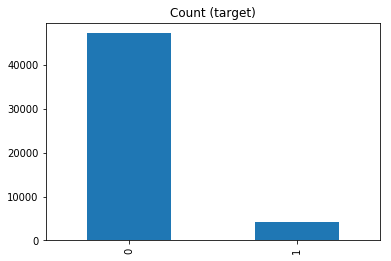

In [0]:
link = "https://drive.google.com/file/d/1zSlMX4ou0q7tfvtzI4uOAf_RHk1JCltZ/view?usp=sharing"
plop, id = link.split('d/')
id, plop = id.split('/view')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile("ConversionDataSet.csv")  
df = pd.read_csv("ConversionDataSet.csv")
df.head()

target_count = df.Kauf.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)')

In the dataset, the columns **category**, **browser**, **operatingSystem** contain categorical data. 

In [0]:
categories = df.category.unique()
print(f"categories : {categories}")
print(f"number of unique categories = {len(categories)}")

browsers = df.browser.unique()
print(f"browsers : {browsers}")
print(f"number of unique browsers = {len(browsers)}")

OS = df.operatingSystem.unique()
print(f"Operating Systems : {OS}")
print(f"number of unique Operating System = {len(OS)}")

categories : ['overview' 'search' 'product' 'account' 'sale' 'home' 'about' 'cart'
 'checkout' 'other']
number of unique categories = 10
browsers : ['IE' 'Firefox' 'Chrome' 'Safari' 'Yandex Browser'
 'Mail.ru Chromium Browser' 'Pale Moon (Firefox Variant)' 'Iceweasel'
 'Maxthon' 'Iron' 'Edge' 'SeaMonkey' 'QQ Browser' 'Lunascape']
number of unique browsers = 14
Operating Systems : ['Windows 7' 'Windows 8' 'Windows 8.1' 'Windows 10' 'Windows Vista'
 'Mac OS X' 'Windows XP' 'Ubuntu' 'Chrome OS' 'Windows RT 8.1' 'Linux'
 'Windows RT']
number of unique Operating System = 12


In [0]:
print(f"total number of rows = {len(df)}")

total number of rows = 51349


We will check if there are any missing values in our data.

In [0]:
isnull = df.isnull().sum() 

print(f"number of columns that contains an empty cell: {len(isnull[isnull>0])}") 

number of columns that contains an empty cell: 0


So, there are no empty cells we have to deal with. We will dummify the categorical columns that we mentioned above.

In [0]:
df = pd.get_dummies(df, prefix=['category', 'browser', 'operatingSystem'])
df.head()

,Unnamed: 0,month,Kauf,sessionStartHour,dayOfMonth,weekday,sessionTime,pageVisitedBeforeSession,amountBasketSession,totalItemValueBasketSession,sessionProduct,sessionSearch,sessionOverview,sessionSale,sessionCart,percPageProduct,percPageSearch,percPageOverview,percPageSale,percPageCart,countPagesRevisited,timeOnPage,checkoutStep,clickEventsSession,scrollEventSession,tabSwitchSession,clickEventProduct,scrollEventProduct,tabSwitchProduct,clickEventSearch,scrollEventSearch,tabSwitchSearch,clickEventOverview,scrollEventOverview,tabSwitchOverview,clickEventSale,scrollEventSale,tabswitchSale,clickEventCart,scrollEventCart,...,windowWidth,windowHeight,tabVisible,visitorKnown,category_about,category_account,category_cart,category_checkout,category_home,category_other,category_overview,category_product,category_sale,category_search,browser_Chrome,browser_Edge,browser_Firefox,browser_IE,browser_Iceweasel,browser_Iron,browser_Lunascape,browser_Mail.ru Chromium Browser,browser_Maxthon,browser_Pale Moon (Firefox Variant),browser_QQ Browser,browser_Safari,browser_SeaMonkey,browser_Yandex Browser,operatingSystem_Chrome OS,operatingSystem_Linux,operatingSystem_Mac OS X,operatingSystem_Ubuntu,operatingSystem_Windows 10,operatingSystem_Windows 7,operatingSystem_Windows 8,operatingSystem_Windows 8.1,operatingSystem_Windows RT,operatingSystem_Windows RT 8.1,operatingSystem_Windows Vista,operatingSystem_Windows XP
0,4,8,0,21,1,6,20,0,0.00,0,0,0,1,1,0,0.00,0.00,0.33,0.33,0.0,0,6,0,3,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.5,0.0,0.0,0.0,0.0,...,1280,844,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,14,8,0,0,1,6,85,1,0.00,0,0,2,0,0,0,0.00,0.67,0.00,0.00,0.0,1,34,0,5,10,3,0.0,0.0,0.0,0.266667,0.112741,0.703125,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,1339,634,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,51,8,0,10,1,6,23,0,0.00,0,0,0,2,0,0,0.00,0.00,0.67,0.00,0.0,0,4,0,3,2,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,...,1600,799,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,60,8,0,8,1,6,162,1,9.95,1,1,0,2,0,0,0.33,0.00,0.67,0.00,0.0,1,67,0,3,23,3,0.5,0.0,1.0,0.000000,0.000000,0.000000,0.666667,0.045554,0.666667,0.0,0.0,0.0,0.0,0.0,...,1280,891,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,70,8,0,17,1,6,52,0,39.90,1,1,0,2,0,0,0.33,0.00,0.67,0.00,0.0,0,6,0,2,3,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.0,0.0,0.0,0.0,0.0,...,1600,775,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


We will prepare the target variable 'Kauf' by keeping it in y and keeping the rest of the data in X. Then, we'll split the data into train and test, using 70% of the data for training. We will scale the data after the train-test split to not introduce future information to out training test. It's important to feed only X_train values to not leak the data to the test set. We will finish the processing of the data by over-sampling the 0s using the SMOTE method to have a balanced dataset.


In [0]:
seed = 101
X = df.drop(["Kauf"], axis=1)
y = df.Kauf
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)    
print(X_train.shape)
print(y_train.shape) 

scaler = StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

(35944, 129)
(35944,)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


We will create our model structure and wrap it into a function called create_model. Then, we will plug it into Keras Classifier Wrapper to use them in the scikit-learnlibrary.

In [0]:
def create_model():
  model = Sequential()
  model.add(Dense(128, activation = 'relu', kernel_initializer=keras.initializers.he_normal(seed=seed), 
                  bias_initializer='zeros', input_shape=(129,)))
  model.add(Dense(128, activation = 'relu', kernel_initializer=keras.initializers.he_normal(seed=seed), 
                  bias_initializer='zeros'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.he_normal(seed=seed),
                  bias_initializer='zeros'))
  model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn = create_model, verbose=0)

We defined the grid search parameters for the batch size and number of epochs.

In [0]:
batchsize = [16, 32, 64, 128]
epochs = [10,25,50]

param_grid = dict(batch_size=batchsize, epochs=epochs)
param_grid 

{'batch_size': [16, 32, 64, 128], 'epochs': [10, 25, 50]}

We will do a grid search to try every combination of batch size and number of epochs values to find the best scoring duo.

In [0]:
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3, n_jobs=-1)
results = grid.fit(X_train, y_train)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.916367 using {'batch_size': 128, 'epochs': 50}


The best scoring duo is found as 64 for the batch size and 50 for the number of epochs. Now, we will fix those parameters and then do a grid search for the best scoring optimizer.

In [0]:
def optim (optimizer='SGD'):
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed),  input_shape=(129,)))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    model.add(Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 
    
    return model

model = KerasClassifier(build_fn=optim, epochs=50, batch_size=64, verbose=0)
# define the grid search parameters
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizers) # setting a dictionary to store the results
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
results = grid.fit(X_train, y_train)

# Our results (reember these are the resultson the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.939269 using {'optimizer': 'Adadelta'}


Best scoring optimizer is found as 'Nadam'. Now we will fix that parameter as well and do a grid search to find the best scoring learning rate.

In [0]:
def create_model_lr(learn_rate=0.01):
  model = Sequential()
  model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed), input_shape=(129,)))
  model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
  model.add(Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.he_normal(seed=seed)))
  optimizer = keras.optimizers.Nadam(lr=learn_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model_lr, epochs=50, batch_size=64, verbose=0)

learn_rate = [0.001, 0.01, 0.1]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.937275 using {'learn_rate': 0.001}


Best scoring learning rate is found as 0.001. Now, we will create our deep neural network model using the best scoring parameters. Best scoring number of hidden layers and number of neurons in a layer are found by manually trying the possibilities.

Train on 66194 samples, validate on 15405 samples
Epoch 1/50
66194/66194 [==============================] - 12s 180us/step - loss: 1.0479 - acc: 0.4592 - val_loss: 0.8201 - val_acc: 0.5598
Epoch 2/50
66194/66194 [==============================] - 5s 77us/step - loss: 0.9563 - acc: 0.4777 - val_loss: 0.8355 - val_acc: 0.5390
Epoch 3/50
66194/66194 [==============================] - 5s 78us/step - loss: 0.8926 - acc: 0.5055 - val_loss: 0.8373 - val_acc: 0.5306
Epoch 4/50
66194/66194 [==============================] - 5s 76us/step - loss: 0.8482 - acc: 0.5205 - val_loss: 0.8282 - val_acc: 0.5325
Epoch 5/50
66194/66194 [==============================] - 5s 74us/step - loss: 0.8141 - acc: 0.5391 - val_loss: 0.8114 - val_acc: 0.5443
Epoch 6/50
66194/66194 [==============================] - 5s 78us/step - loss: 0.7916 - acc: 0.5495 - val_loss: 0.7930 - val_acc: 0.5568
Epoch 7/50
66194/66194 [==============================] - 5s 77us/step - loss: 0.7733 - acc: 0.5597 - val_loss: 0.7732 - val_a

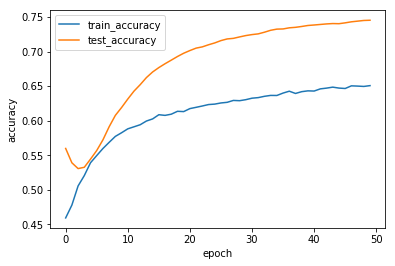

In [0]:
early_stopping_monitor = EarlyStopping(patience=7)
batch_size = 64 
epochs = 50
learning_rate = 0.001
#decay_rate = learning_rate / epochs
#momentum = 0.8

model_final = Sequential()
model_final.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed), input_shape=(129,)))
model_final.add(Dropout(0.1))
model_final.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
model_final.add(Dropout(0.1))
model_final.add(Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.he_normal(seed=seed)))

opt = keras.optimizers.Adadelta(lr=learning_rate)
model_final.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy'])

#And now we fit the model (that is the training part), mind that saving it to the variable will help you retrieve and analyse the training history
story = model_final.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor])

#score = model.evaluate(X_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

def show_history(story):
    plt.plot(story.history['acc'])
    plt.plot(story.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

show_history(story)

We will predict the target values in our test set and compare our predictions with the real outcomes. Then we will calculate performance measures such as accuracy, precision, recall and F1 score.

In [0]:
yhat_probs = model_final.predict(X_test, verbose=0)
yhat_classes = model_final.predict_classes(X_test, verbose=0)

We need to reduce the array for predictions to 1d to be able to use it in confusion matrix.

In [0]:
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [0]:
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.745407
Precision: 0.162732
Recall: 0.506719
F1 score: 0.246349


Our model's accuracy is found as 0.85 which means that 85% of the target variables are correctly identified.  Precision score is found as 0.23, which means that 23% of the predicted conversions by the model actually turned out to be actual conversions by the clients. Recall score is found as 0.34, which means that our model correctly spotted 34% of all the actual conversions by the clients.

In [0]:
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)

ROC AUC: 0.680149


ROC AUC value is found as 0.68 which is higher than the benchmark value of 0.6 that is given in the task description.

In [0]:
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[10842  3298]
 [  624   641]]


From the confusion matrix we can see that 12699 of the target variable 0s and 428 of the target variable 1s are correctly identified by the model. 1441 of the target variable 0s are incorrectly identified as 1 by the model and 837 of the target variable 1s are incorrectly identified as 0 by the model. 